In [25]:
import transformers
print(transformers.__version__)


4.40.1


In [26]:
from datasets import load_dataset

ds = load_dataset("YuvrajSingh9886/Agriculture-Soil-QA-Pairs-Dataset")

In [27]:
ds

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'ANSWER', 'QUESTION.question', 'QUESTION.paragraph'],
        num_rows: 3447
    })
})

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import evaluate
import re
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    T5Tokenizer,
    default_data_collator,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq
)

from transformers import pipeline
from transformers import set_seed
set_seed(42)

In [29]:
split_dataset = ds["train"].train_test_split(test_size=0.2, seed=42)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'ANSWER', 'QUESTION.question', 'QUESTION.paragraph'],
        num_rows: 2757
    })
    test: Dataset({
        features: ['Unnamed: 0', 'ANSWER', 'QUESTION.question', 'QUESTION.paragraph'],
        num_rows: 690
    })
})

In [30]:
questions = ["question: " + q for q in split_dataset['train']['QUESTION.question']]
answers = [a for a in split_dataset['train']['ANSWER']]

df = pd.DataFrame({'questions': questions, 'answers': answers})
df


,questions,answers
0,question: What is often rewarded under agri-en...,Semi-natural habitats
1,question: When can the harvesting process for ...,The harvesting process for these crops can gen...
2,question: What can help optimize nutrient cycl...,Variety and species mixtures (intercrops).
3,question: What is included in the assessment o...,Number of earthworm burrows and extent of visi...
4,question: How can soil-borne pest build-up ass...,Soil-borne pest build-up can be avoided by pra...
...,...,...
2752,question: Why is it important to incorporate t...,To ensure minimal nitrogen loss
2753,question: How do microbes contribute to nutrie...,Microbes contribute to nutrient availability b...
2754,question: How does the hand texturing method c...,"In the hand texturing method, soil that forms ..."
2755,question: List methods to minimize soil compac...,"To minimize soil compaction from machinery, on..."


In [31]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

#Ensure CUDA is used if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define max lengths
max_input_length = 256
max_target_length = 64

# Define the preprocessing function
def preprocess(batch):
    inputs = ["question: " + q.strip() for q in batch["QUESTION.question"]]
    targets = [a[0] if isinstance(a, list) else a for a in batch["ANSWER"]]
    
    model_inputs = tokenizer(inputs, 
                             max_length=max_input_length, 
                             truncation=True, 
                             padding=True)
    
    labels = tokenizer(targets, 
                       max_length=max_target_length, 
                       truncation=True, 
                       padding=True)
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the preprocessing
train_dataset = split_dataset["train"].map(preprocess, batched=True)
test_dataset = split_dataset["test"].map(preprocess, batched=True)


c:\Users\ayush\anaconda3\envs\tf\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if hasattr(preds, "dim"):
        preds = preds.argmax(dim=-1)
    else:
        preds = np.argmax(preds, axis=-1)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(pred.strip().split(". ")) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip().split(". ")) for label in decoded_labels]

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    result = {key: round(value * 100, 4) for key, value in result.items()}

    return result


In [33]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir = "./t5-agri-qa",
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 4,
    num_train_epochs = 3,
    learning_rate = 5e-5,
    evaluation_strategy = "epoch",      
    save_strategy = "epoch",             
    logging_dir = "./logs",             
    logging_steps = 10,
    predict_with_generate = True,
    fp16 = True,
    save_total_limit = 2,
)

trainer = Seq2SeqTrainer(
    model             = model,
    args              = training_args,
    train_dataset     = train_dataset,
    eval_dataset      = test_dataset,
    data_collator     = data_collator,
    tokenizer         = tokenizer,
    compute_metrics   = compute_metrics,
)

In [34]:
trainer.train()
trainer.save_model("./t5-agri-qa") 

  0%|          | 0/258 [00:00<?, ?it/s]

{'loss': 8.611, 'grad_norm': 20.78984260559082, 'learning_rate': 4.8062015503875976e-05, 'epoch': 0.12}
{'loss': 2.6468, 'grad_norm': 1.9032557010650635, 'learning_rate': 4.6124031007751936e-05, 'epoch': 0.23}
{'loss': 1.8645, 'grad_norm': 1.3437389135360718, 'learning_rate': 4.418604651162791e-05, 'epoch': 0.35}
{'loss': 1.7265, 'grad_norm': 1.7292717695236206, 'learning_rate': 4.2248062015503877e-05, 'epoch': 0.46}
{'loss': 1.5243, 'grad_norm': 1.0560312271118164, 'learning_rate': 4.0310077519379843e-05, 'epoch': 0.58}
{'loss': 1.4319, 'grad_norm': 0.8209211230278015, 'learning_rate': 3.837209302325582e-05, 'epoch': 0.7}
{'loss': 1.4533, 'grad_norm': 0.8317121267318726, 'learning_rate': 3.6434108527131784e-05, 'epoch': 0.81}
{'loss': 1.413, 'grad_norm': 1.2472033500671387, 'learning_rate': 3.449612403100775e-05, 'epoch': 0.93}


c:\Users\ayush\anaconda3\envs\tf\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 1.2735306024551392, 'eval_rouge1': 0.2161, 'eval_rouge2': 0.0, 'eval_rougeL': 0.2143, 'eval_rougeLsum': 0.2153, 'eval_runtime': 157.7957, 'eval_samples_per_second': 4.373, 'eval_steps_per_second': 0.551, 'epoch': 1.0}
{'loss': 1.4061, 'grad_norm': 0.9429342150688171, 'learning_rate': 3.2558139534883724e-05, 'epoch': 1.04}
{'loss': 1.349, 'grad_norm': 0.898872435092926, 'learning_rate': 3.062015503875969e-05, 'epoch': 1.16}
{'loss': 1.3734, 'grad_norm': 0.77265465259552, 'learning_rate': 2.868217054263566e-05, 'epoch': 1.28}
{'loss': 1.2805, 'grad_norm': 1.0102753639221191, 'learning_rate': 2.674418604651163e-05, 'epoch': 1.39}
{'loss': 1.3253, 'grad_norm': 0.735115110874176, 'learning_rate': 2.48062015503876e-05, 'epoch': 1.51}
{'loss': 1.3785, 'grad_norm': 0.8996531963348389, 'learning_rate': 2.2868217054263565e-05, 'epoch': 1.62}
{'loss': 1.2792, 'grad_norm': 0.6612233519554138, 'learning_rate': 2.0930232558139536e-05, 'epoch': 1.74}
{'loss': 1.2172, 'grad_norm': 0.7478

c:\Users\ayush\anaconda3\envs\tf\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 1.2060703039169312, 'eval_rouge1': 0.7472, 'eval_rouge2': 0.0, 'eval_rougeL': 0.745, 'eval_rougeLsum': 0.7436, 'eval_runtime': 169.1676, 'eval_samples_per_second': 4.079, 'eval_steps_per_second': 0.514, 'epoch': 1.99}
{'loss': 1.2891, 'grad_norm': 0.7538323402404785, 'learning_rate': 1.5116279069767441e-05, 'epoch': 2.09}
{'loss': 1.2723, 'grad_norm': 0.5896371603012085, 'learning_rate': 1.3178294573643413e-05, 'epoch': 2.2}
{'loss': 1.264, 'grad_norm': 0.6710590720176697, 'learning_rate': 1.1240310077519382e-05, 'epoch': 2.32}
{'loss': 1.2626, 'grad_norm': 0.5775766372680664, 'learning_rate': 9.302325581395349e-06, 'epoch': 2.43}
{'loss': 1.2701, 'grad_norm': 0.9357897043228149, 'learning_rate': 7.364341085271319e-06, 'epoch': 2.55}
{'loss': 1.2404, 'grad_norm': 0.5922541618347168, 'learning_rate': 5.426356589147287e-06, 'epoch': 2.67}
{'loss': 1.2481, 'grad_norm': 0.6117753386497498, 'learning_rate': 3.488372093023256e-06, 'epoch': 2.78}
{'loss': 1.2998, 'grad_norm': 0.

c:\Users\ayush\anaconda3\envs\tf\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 1.1947771310806274, 'eval_rouge1': 0.7379, 'eval_rouge2': 0.0, 'eval_rougeL': 0.7352, 'eval_rougeLsum': 0.7348, 'eval_runtime': 66.595, 'eval_samples_per_second': 10.361, 'eval_steps_per_second': 1.306, 'epoch': 2.99}
{'train_runtime': 912.7236, 'train_samples_per_second': 9.062, 'train_steps_per_second': 0.283, 'train_loss': 1.6955944327420966, 'epoch': 2.99}


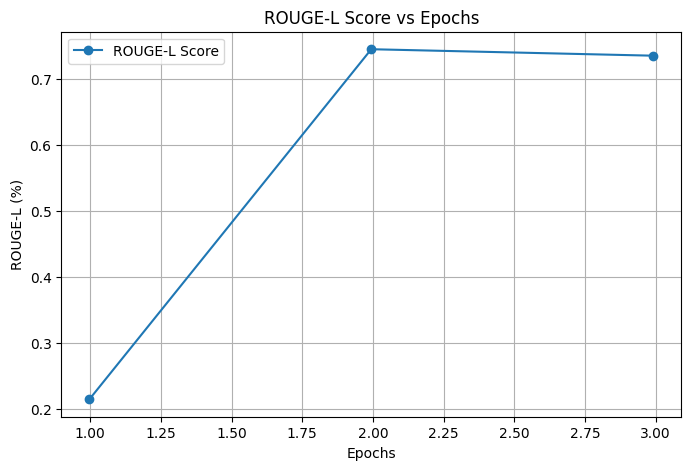

In [36]:
import json


# Read all log files (they are saved in 'trainer_state.json')
with open("t5-agri-qa/checkpoint-258/trainer_state.json", "r") as f:
    logs = json.load(f)

training_logs = logs["log_history"]

# Extract rougeL scores and epochs
epochs = []
rougeL = []

for log in training_logs:
    if "eval_rougeL" in log:
        epochs.append(log["epoch"])
        rougeL.append(log["eval_rougeL"])

# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs, rougeL, marker="o", label="ROUGE-L Score")
plt.title("ROUGE-L Score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("ROUGE-L (%)")
plt.grid(True)
plt.legend()
plt.show()
